To Load the DataSet into this workspace, the raw files were first uploaded into a shared Google Drive folder. After that, using the library **gdown**, the dataset was unzipped into a location which could be easily accessed by this code.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dilipis/CourseProject/blob/main/Sentiment_Analysis_with_BERT.ipynb)

In [ ]:
# Refer https://colab.research.google.com/notebooks/io.ipynb for file copy help
 
import gdown
 
# url = 'https://drive.google.com/uc?id=1IuEaRnCUA-TSzQC177PIRLUXhrx63dh6'  # 42 images
url = 'https://drive.google.com/uc?id=1ZrnMdjrJAyJwdsH1L2W6pmL8hjFFuhqw' # entire datset
 
zipfile = 'dataset.zip'
unzip_loc = '/content/data/'
 
gdown.download(url, zipfile, quiet=False)
 
!unzip -q "{zipfile}" -d "{unzip_loc}"
 
# Remove zip
!rm "{zipfile}"
 
# # Clear dataset folder ONLY if reqd
# !rm -rf "{unzip_loc}"

Downloading...
From: https://drive.google.com/uc?id=1ZrnMdjrJAyJwdsH1L2W6pmL8hjFFuhqw
To: /content/dataset.zip
1.56GB [00:13, 112MB/s] 


Using **!pip**, any package which is not available by default in google colab can be imported.

In [ ]:
!pip install utils

Creating the Data Path from where the images can be accessed.

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils as utils
import time; _START_RUNTIME = time.time()
from fastai.vision import *
# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Define data path
DATA_PATH = "/content/data/"
print (DATA_PATH)
assert os.path.isdir(DATA_PATH)

/content/data/


The code snippet below splits the data into 60:20:20 as train:val:test and separates them out as different folder structure with COVID and Non-COVID folders within each. 


```
data
  |
  |
  |---train
  |     |
  |     |-COVID(25 images)
  |     |-Non-COVID(25 images)
  |
  |---val
  |     |
  |     |-COVID (8 images)
  |     |-Non-COVID (8 images)
  |
  |
  |---test
  |     |
  |     |-COVID (9 Images)
  |     |-Non-COVID (9 Images)
```


  

In [ ]:
import os
import numpy as np
import shutil
import random
root_dir = '/content/data/' # data root path
classes_dir = ['COVID', 'Non-COVID'] #total labels

val_ratio = 0.20
test_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'val/' + cls)
    os.makedirs(root_dir +'test/' + cls)


# Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.seed(12345)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)

Total images:  3616
Training:  2169
Validation:  723
Testing:  724
Total images:  3616
Training:  2169
Validation:  723
Testing:  724


In [ ]:
def load_data(data_path=DATA_PATH):
    
    import torchvision
    import torchvision.datasets as datasets
    import torchvision.transforms as transforms
    
   
    BATCH_SIZE = 32
    TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train')
    TEST_DATA_PATH = os.path.join(DATA_PATH, 'val')
    TRANSFORM_IMG = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
    ])

    train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
    val_loader  = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False) 


    
  
    return train_loader, val_loader

In [ ]:
train_loader, val_loader = load_data()   

# images, labels = next(iter(train_loader))
# print (images, labels)

'''
Check which label has been assigned to what
'''
train_loader.class_to_idx

{'COVID': 0, 'Non-COVID': 1}

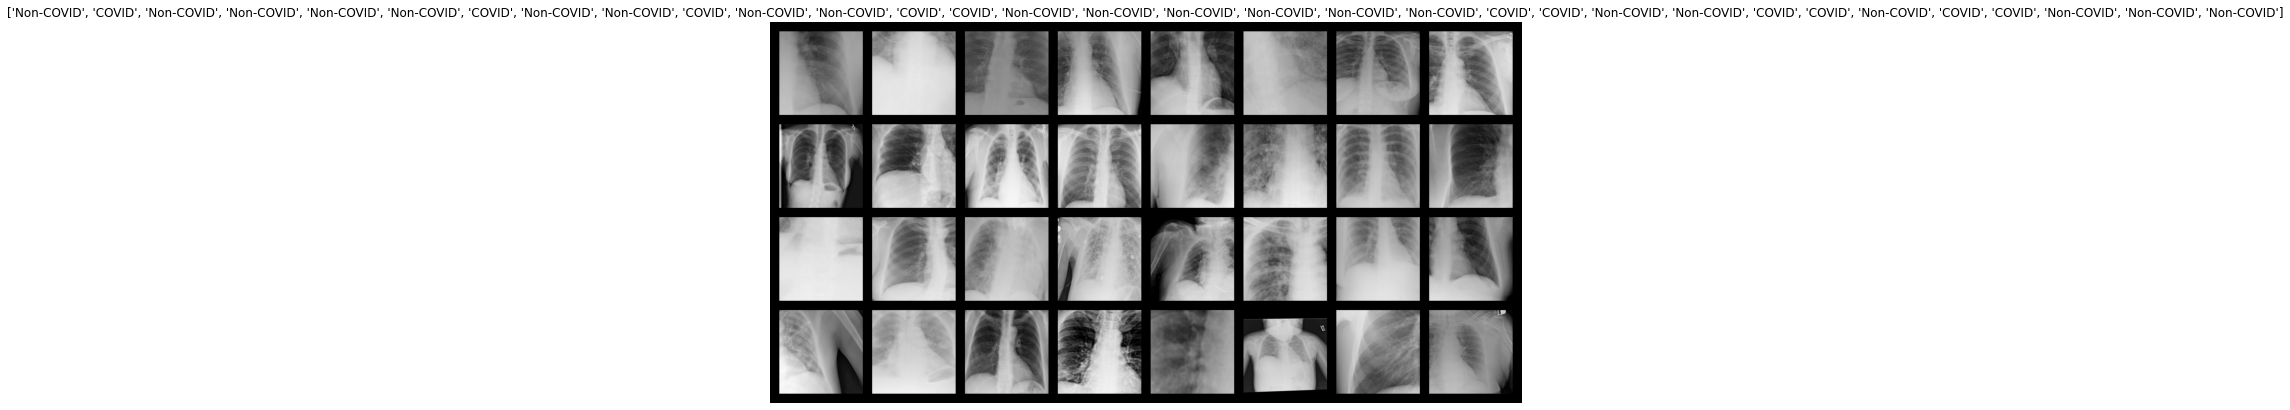

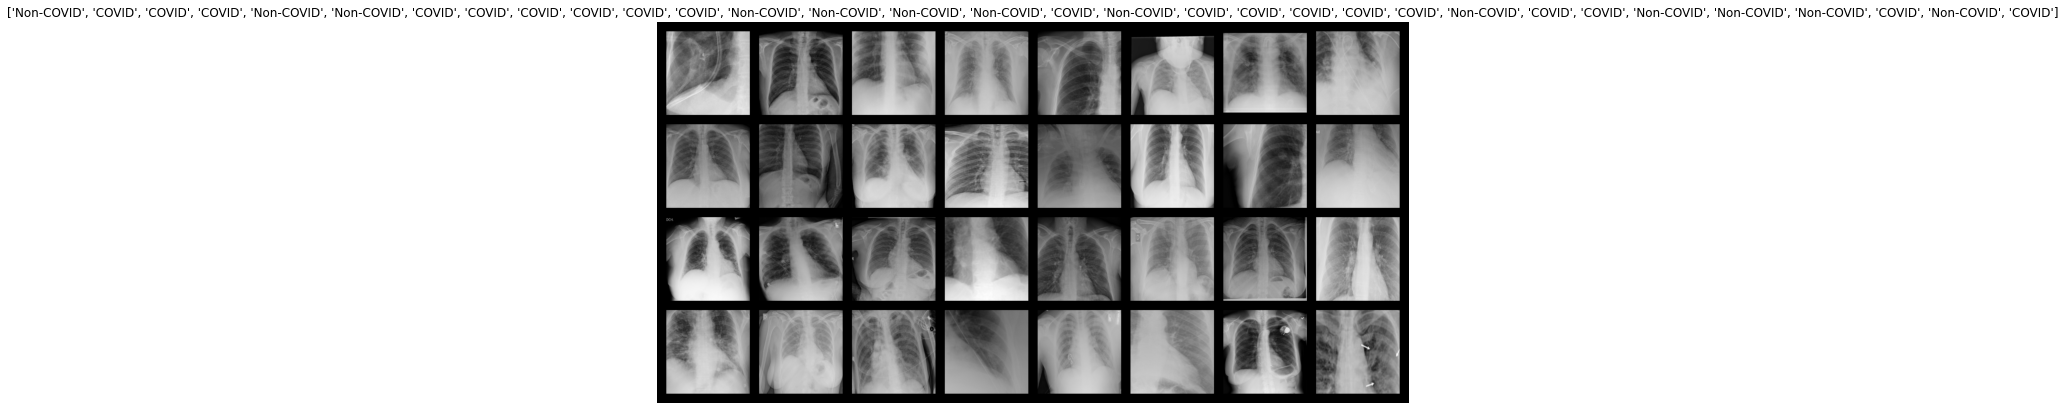

In [ ]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["COVID" if x==0  else "Non-COVID" for x in labels])

train_loader, val_loader = load_data()   
for i in range(2):
    show_batch_images(train_loader)

Modeling the CNN layers according to the paper on 
[EMCNet](https://www.sciencedirect.com/science/article/pii/S2352914820306560#bib47) 

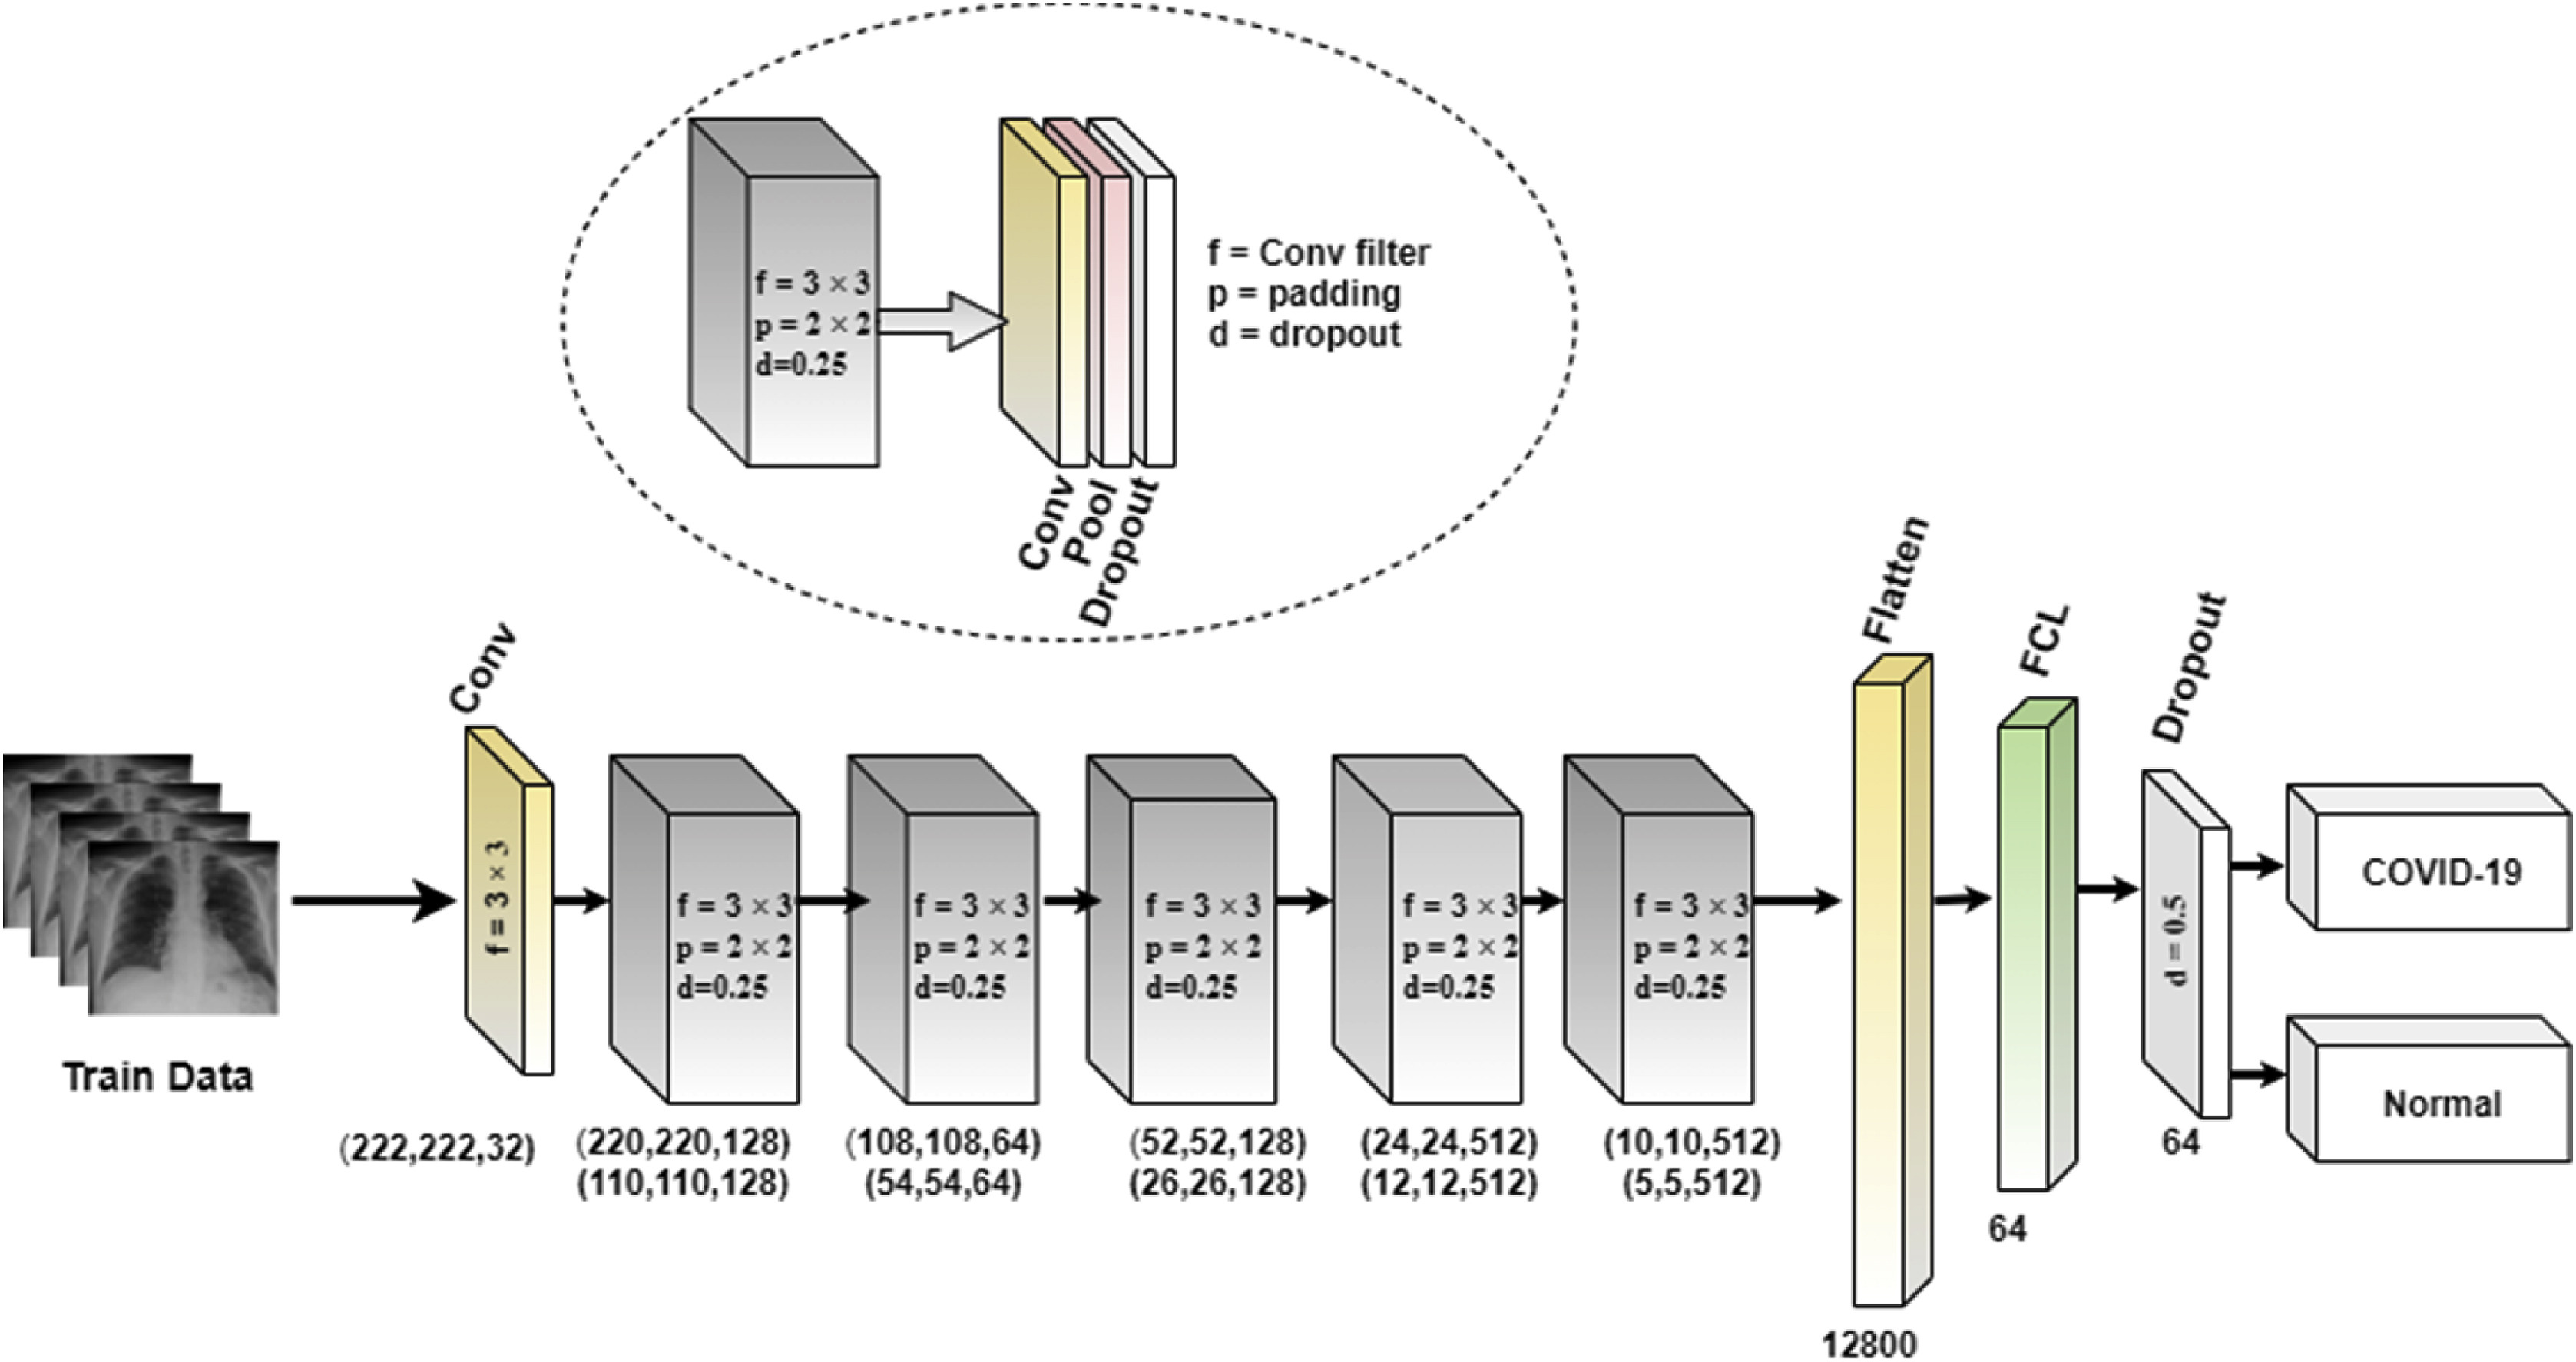

In [ ]:
class EMCNet(nn.Module):
    def __init__(self):
        super(EMCNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(128, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 512, 3)
        self.conv6 = nn.Conv2d(512, 512, 3)
        self.fc1 = nn.Linear(12800, 64)
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(p=0.25)
        self.dropout1 = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        #input is of shape (batch_size=32, 3, 224, 224) if you did the dataloader right
        # your code here
        # print (x.shape)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.dropout(x)
        # print ("hi there")
        # print (x.shape)
        x = x.view(-1, 12800)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        # print (x.shape)
        return x
    # def num_flat_features(self, x):
    #     size = x.size()[1:]  # all dimensions except the batch dimension
    #     num_features = 1
    #     for s in size:
    #         num_features *= s
    #     return num_features


In [ ]:
model = EMCNet()

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
n_epochs = 20

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
  
    model.train() # prep model for training
    
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_dataloader:
            # your code here
            optimizer.zero_grad()
            data = data.to(device)
            target = target.to(device)
            target_hat = model(data)
            loss = criterion(target_hat, target)
            loss.backward()
            optimizer.step()
            curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
    return model


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_loader, val_loader = load_data()

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
model = model.to(device)
model = train_model(model, train_loader)



Epoch 0: curr_epoch_loss=0.6936473846435547
Epoch 1: curr_epoch_loss=0.693225622177124
Epoch 2: curr_epoch_loss=0.6932282447814941
Epoch 3: curr_epoch_loss=0.6923755407333374
Epoch 4: curr_epoch_loss=0.6816542744636536
Epoch 5: curr_epoch_loss=0.6635161638259888
Epoch 6: curr_epoch_loss=0.6699739694595337
Epoch 7: curr_epoch_loss=0.643636167049408
Epoch 8: curr_epoch_loss=0.6489834189414978
Epoch 9: curr_epoch_loss=0.7258669137954712
Epoch 10: curr_epoch_loss=0.8132615089416504
Epoch 11: curr_epoch_loss=0.8129040598869324
Epoch 12: curr_epoch_loss=0.8139764070510864
Epoch 13: curr_epoch_loss=0.8130828142166138
Epoch 14: curr_epoch_loss=0.8127253651618958
Epoch 15: curr_epoch_loss=0.8132859468460083
Epoch 16: curr_epoch_loss=0.8136189579963684
Epoch 17: curr_epoch_loss=0.8125466108322144
Epoch 18: curr_epoch_loss=0.8138487339019775
Epoch 19: curr_epoch_loss=0.8136189579963684


In [ ]:
def eval_model(model, dataloader):
    """
    :return:
        Y_pred: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints
    TODO:
        evaluate the model using on the data in the dataloder.
        Add all the prediction and truth to the corresponding list
        Convert Y_pred and Y_test to numpy arrays (of shape (n_data_points, 2))
    """
    model.eval()
    Y_pred = []
    Y_test = []
    for data, target in dataloader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        _, y_pred_tag = torch.max(y_pred, dim = 1) 
        
        Y_pred = np.append(Y_pred,y_pred_tag.cpu().detach().numpy())
        Y_test = np.append(Y_test,target.cpu().numpy())
        
        
#     Y_pred = np.concatenate(Y_pred, axis=0)
#     Y_test = np.concatenate(Y_test, axis =0)

    return Y_pred, Y_test
    

In [ ]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''
from sklearn.metrics import accuracy_score

y_pred, y_true = eval_model(model, val_loader)
acc = accuracy_score(y_true, y_pred)
print(("Validation Accuracy: " + str(acc)))




Validation Accuracy: 0.5


In [ ]:
# probs = np.argmax(y_pred)
# correct = 0
# for idx, pred in enumerate(probs):
#     if pred == y_true[idx]:
#         correct += 1
# accuracy = correct / len(probs)
# print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(y_true, y_pred)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = y_true
y_pred1 = y_pred
target_names = ['Covid', 'Non COVID']
print(classification_report(y_true1, y_pred1, target_names=target_names))

[[  0 723]
 [  0 723]]
              precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       723
   Non COVID       0.50      1.00      0.67       723

    accuracy                           0.50      1446
   macro avg       0.25      0.50      0.33      1446
weighted avg       0.25      0.50      0.33      1446



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


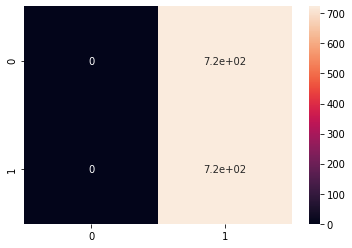

In [ ]:
import seaborn as sns
sns.heatmap(cm1, annot=True)

In [ ]:
sns.heatmap(cm1/np.sum(cm1), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues')

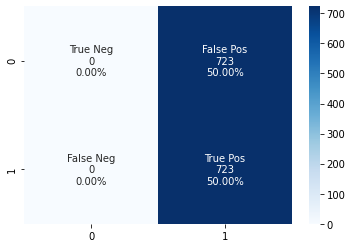

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm1.flatten()/np.sum(cm1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues')